In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr


In [2]:
#get datasets
household_data = pd.read_csv("NHST_Data\hhpub.csv")
person_data = pd.read_csv("NHST_Data\perpub.csv")
trip_data = pd.read_csv("NHST_Data\\trippub.csv")
vehicle_data = pd.read_csv("NHST_Data\\vehpub.csv")
gas_data = pd.read_csv("data_with_gas_usage.csv")

#use data with vehicles that only use gasoline 
#vehicle_data = vehicle_data.loc[vehicle_data['VEHFUEL'].between(1,2)]
gas_data = gas_data.loc[gas_data['VEHFUEL'] == 1]
gas_data = gas_data.loc[gas_data['GASUSGE'].notna()]

In [3]:
#set up new dataset including unique id from vehicle data
df = pd.DataFrame({'HOUSEID' : pd.unique(gas_data['HOUSEID']),
                   'ANNMILES' : 0, 'GASUSGE' : 0,
                   'HighestEDUC' : 0,
                   
                   'TAXISERVICE' : 0, 'RIDESHARE22' : 0, 'ESCOOTERUSED' : 0,
                   'PTUSED' : 0, 'MCTRANSIT' : 0, 'WALKTRANSIT' : 0, 
                   'BIKETRANSIT' : 0, 'EMPLOYMENT2' : 0,
                  })

person_col = ['TAXISERVICE', 'RIDESHARE22', 'ESCOOTERUSED', 'PTUSED', 'MCTRANSIT', 'WALKTRANSIT', 'BIKETRANSIT', 'EMPLOYMENT2']

#add empty columns from household data
for col_name in household_data.columns:
    if col_name != 'HOUSEID':
        df[col_name] = 0
        
for i in df.index:
    #get total gasuage of each household
    id = gas_data.loc[gas_data['HOUSEID'] == df['HOUSEID'][i]].index
    if(not id.empty):
        df.loc[i, 'ANNMILES'] = gas_data['ANNMILES'][id].sum()
        df.loc[i, 'GASUSGE'] = gas_data['GASUSGE'][id].sum()
    
    #get all column values from household data
    id = household_data.loc[household_data['HOUSEID'] == df['HOUSEID'][i]].index[0]
    for col_name in household_data.columns:
        if col_name != 'HOUSEID':
            df.loc[i, col_name] = household_data[col_name][id]
    
         
    id = person_data.loc[person_data['HOUSEID'] == df['HOUSEID'][i]].index
    df.loc[i, 'HighestEDUC'] = max(df.loc[i, 'HighestEDUC'], person_data['EDUC'][id].max())  #get highest education level of each household
    
    for col in person_col:
        #get the number of days where certain alternative travel methods are used by the household in a month
        df.loc[i, col] = max(0, person_data.iloc[id].loc[person_data[col] >= 0][col].sum())


df_super = df.loc[df['GASUSGE'] >= df.GASUSGE.quantile(0.9)] #dataset containing only super users
df_nonsuper = df.loc[df['GASUSGE'] < df.GASUSGE.quantile(0.9)] #dataset containing only non-super users


#df

C:\Users\Razer\AppData\Local\Temp\ipykernel_4428\1535646700.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '408.25815788742875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'GASUSGE'] = gas_data['GASUSGE'][id].sum()
C:\Users\Razer\AppData\Local\Temp\ipykernel_4428\1535646700.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4683.5625987' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, col_name] = household_data[col_name][id]
C:\Users\Razer\AppData\Local\Temp\ipykernel_4428\1535646700.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14269.464209' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, col_name] = hous

In [4]:
df

,HOUSEID,ANNMILES,GASUSGE,HighestEDUC,TAXISERVICE,RIDESHARE22,ESCOOTERUSED,PTUSED,MCTRANSIT,WALKTRANSIT,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
0,9000013002,12000,408.258158,7,0,0,0,0,0,13,...,1,4,1,2,0,4,1,202202,1,1021
1,9000013016,10000,356.835885,6,0,0,0,0,0,7,...,1,2,1,0,0,2,1,202202,2,1021
2,9000013039,5000,171.387563,6,0,0,0,0,0,8,...,1,4,1,2,0,4,1,202201,1,1021
3,9000013041,5000,173.118751,6,0,0,0,0,0,0,...,1,3,1,0,0,1,1,202201,1,1021
4,9000013042,70020,2414.157750,8,0,3,0,8,0,9,...,1,4,1,0,1,2,1,202202,2,1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,9000218006,11000,374.625041,7,0,0,0,0,0,0,...,1,3,1,2,0,3,1,202212,1,1031
7162,9000218013,3000,102.395445,7,0,0,0,0,0,3,...,1,1,1,0,0,2,1,202301,0,1031
7163,9000218021,12100,421.380431,6,0,0,0,0,0,0,...,4,6,2,0,0,1,2,202212,0,1032
7164,9000218034,10000,482.619553,2,0,0,0,0,0,0,...,4,6,2,0,0,2,2,202212,0,1032


In [5]:
print('Super user average travel data')
print(df_super['ANNMILES'].values.mean(), 'ANNMILES')
print(df_super['GASUSGE'].values.mean(), 'GASUSGE\n')

print('Non superuser average travel data')
print(df_nonsuper['ANNMILES'].values.mean(), 'ANNMILES')
print(df_nonsuper['GASUSGE'].values.mean(), 'GASUSGE\n')

print('Ratio of gasoline used by super users vs all users: ', end='')
print(df_super['ANNMILES'].values.sum()/df['ANNMILES'].values.sum())


Super user average travel data
125116.35285913528 ANNMILES
5092.850155014935 GASUSGE

Non superuser average travel data
13035.202046828967 ANNMILES
499.0952099144215 GASUSGE

Ratio of gasoline used by super users vs all users: 0.5162408000444582


In [6]:
#search for difference of columns between two dataset
#list(set(person_data.columns) - set(household_data.columns))

In [7]:
#df.isna().sum()


In [8]:
#person_data['CNTTDTR'].value_counts()

In [9]:
#print(household_data.columns)
#print(person_data.columns)
#print(trip_data.columns)
#print(vehicle_data.columns)


In [10]:
s_corrlation = {}
s_pValues = {}
p_corrlation = {}
for column in df:
    corr_s, pval_s = spearmanr(df['GASUSGE'],df[column], nan_policy='omit')
    corr_p = pearsonr(df['GASUSGE'],df[column])
    s_corrlation[column] = corr_s
    s_pValues[column] = pval_s
    p_corrlation[column] = corr_p

sorted_items = sorted(s_corrlation.items(), key=lambda item: item[1], reverse=True)
for key, value in sorted_items:
    if(value < 0.2):
        break
    print(key, value, s_pValues[key])
    

sorted(p_corrlation.items(), key=lambda item: item[1], reverse=True)

GASUSGE 0.9999999999999998 0.0
ANNMILES 0.9886484323248939 0.0
HHVEHCNT 0.3603238588775356 1.1838278522861857e-218
WRKCOUNT 0.3064149294598287 1.2862776161542957e-155
EMPLOYMENT2 0.2998280081471766 9.109237822280952e-149
DRVRCNT 0.29160454700096977 1.8314529362977345e-140
RESP_CNT 0.2784709571095975 9.134944059140178e-128
HHSIZE 0.27722465089496173 1.3494784724626566e-126
NUMADLT 0.23914437702276736 9.595169699569456e-94
CNTTDHH 0.20337564270463968 8.956549300772374e-68
HHFAMINC_IMP 0.20321690563077985 1.1407994348230238e-67
HHFAMINC 0.2025578922670105 3.107889211032248e-67


[('GASUSGE', PearsonRResult(statistic=0.999999999999999, pvalue=0.0)),
 ('ANNMILES', PearsonRResult(statistic=0.9775950989291574, pvalue=0.0)),
 ('HHVEHCNT',
  PearsonRResult(statistic=0.15506911829898218, pvalue=8.25342411313303e-40)),
 ('HHSIZE',
  PearsonRResult(statistic=0.12703123240494613, pvalue=3.6204318179493784e-27)),
 ('RESP_CNT',
  PearsonRResult(statistic=0.12325234521368365, pvalue=1.16515008040843e-25)),
 ('DRVRCNT',
  PearsonRResult(statistic=0.11347365043565337, pvalue=5.675036595938819e-22)),
 ('WRKCOUNT',
  PearsonRResult(statistic=0.10421820731258344, pvalue=9.164448047037724e-19)),
 ('PPT517',
  PearsonRResult(statistic=0.09767655501816985, pvalue=1.1622165955613234e-16)),
 ('EMPLOYMENT2',
  PearsonRResult(statistic=0.09739194150111813, pvalue=1.4246792185375317e-16)),
 ('NUMADLT',
  PearsonRResult(statistic=0.09339945808268287, pvalue=2.329409654094856e-15)),
 ('FLAG100',
  PearsonRResult(statistic=0.06321187511583003, pvalue=8.534433478857989e-08)),
 ('MSACAT',
 

In [11]:
#df['CNTTDHH'].value_counts()

Text(0.5, 1.0, 'Household driver count')

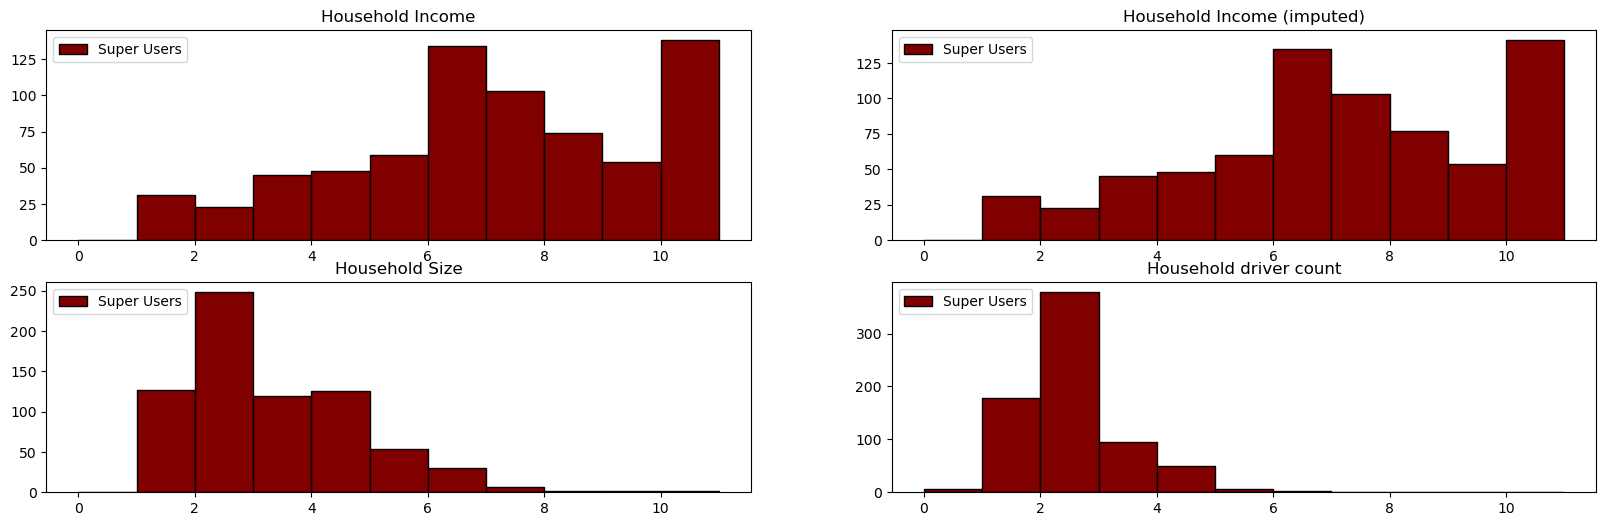

In [12]:
color = ['maroon', 'palegreen', 'gray']
label = ['Super Users', 'Non Super Users', 'All Users']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, figsize=(20,6))
#ax0.hist([df_super['HHFAMINC'], df_nonsuper['HHFAMINC'], df['HHFAMINC']], bins= np.arange(0,12), color=color, edgecolor = 'black', label=label)
ax0.hist(df_super['HHFAMINC'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax0.legend(loc=2)
ax0.set_title('Household Income')

#ax1.hist([df_super['HHFAMINC_IMP'], df_nonsuper['HHFAMINC_IMP'], df['HHFAMINC_IMP']], bins= np.arange(0,8), color=color, edgecolor = 'black', label=label)
ax1.hist(df_super['HHFAMINC_IMP'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax1.legend(loc=2)
ax1.set_title('Household Income (imputed)')

#ax2.hist([df_super['HHSIZE'], df_nonsuper['HHSIZE'], df['HHSIZE']], bins= np.arange(0,11), color=color, edgecolor = 'black', label=label)
ax2.hist(df_super['HHSIZE'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax2.legend(loc=2)
ax2.set_title('Household Size')

#ax3.hist([df_super['DRVRCNT'], df_nonsuper['DRVRCNT'], df['DRVRCNT']], bins= np.arange(0,8), color=color, edgecolor = 'black', label=label)
ax3.hist(df_super['DRVRCNT'], bins= np.arange(0,12), color=color[0], edgecolor = 'black', label=label[0])
ax3.legend(loc=2)
ax3.set_title('Household driver count')

Text(0.5, 1.0, 'Household vehicle count')

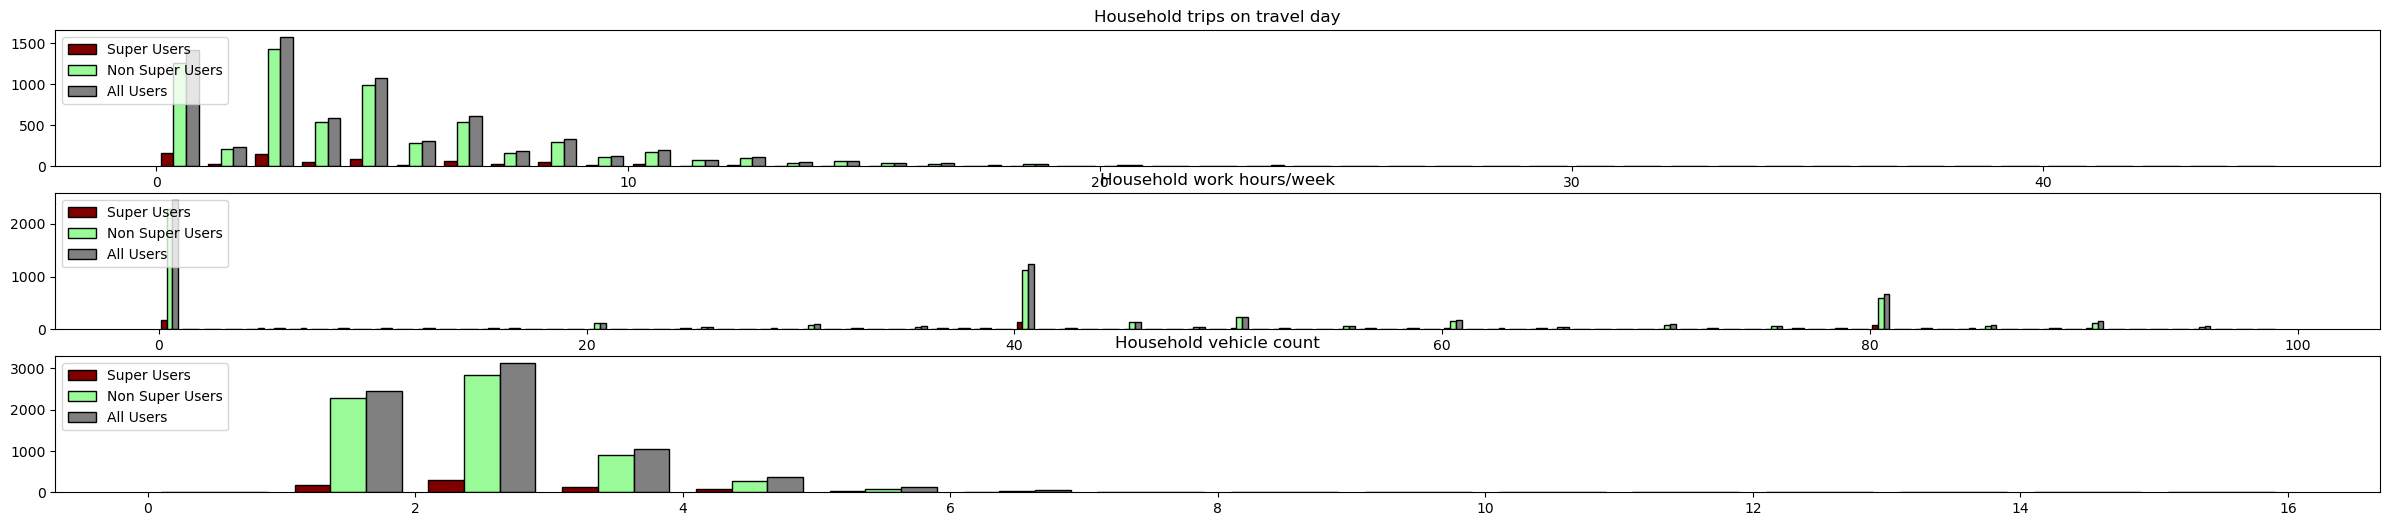

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, ncols = 1, figsize=(30,6))
ax0.hist([df_super['CNTTDHH'], df_nonsuper['CNTTDHH'], df['CNTTDHH']], bins= np.arange(0,46), color=color, edgecolor = 'black', label=label)
ax0.legend(loc=2)
ax0.set_title('Household trips on travel day')

ax1.hist([df_super['EMPLOYMENT2'], df_nonsuper['EMPLOYMENT2'], df['EMPLOYMENT2']], bins= np.arange(0,100), color=color, edgecolor = 'black', label=label)
ax1.legend(loc=2)
ax1.set_title('Household work hours/week')

ax2.hist([df_super['HHVEHCNT'], df_nonsuper['HHVEHCNT'], df['HHVEHCNT']], bins= np.arange(0,17), color=color, edgecolor = 'black', label=label)
ax2.legend(loc=2)
ax2.set_title('Household vehicle count')

In [14]:
#standard scaling all numeric values
num_col = person_col + ["GASUSGE", "WTHHFIN", "WTHHFIN5D",
                        "WTHHFIN2D", "NUMADLT", 'DRVRCNT',
                        'CNTTDHH', 'HHSIZE', 'HHVEHCNT',
                        'PPT517', 'YOUNGCHILD', 'RESP_CNT',
                        'WRKCOUNT',
                        ]

# standard_scaler = StandardScaler()
# for col in num_col:
#     df[col] = standard_scaler.fit_transform(df[[col]])
# df

In [15]:
df.to_csv("processed_data.csv", index=False)
df_super.to_csv("processed_data_superuserOnly.csv", index=False)
df_nonsuper.to_csv("processed_data_nonSuperuserOnly.csv", index=False)

In [16]:
display(df_super)
display(df_nonsuper)

,HOUSEID,ANNMILES,GASUSGE,HighestEDUC,TAXISERVICE,RIDESHARE22,ESCOOTERUSED,PTUSED,MCTRANSIT,WALKTRANSIT,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
4,9000013042,70020,2414.157750,8,0,3,0,8,0,9,...,1,4,1,0,1,2,1,202202,2,1021
28,9000013256,69647,2474.691223,7,0,0,0,0,0,0,...,4,6,2,0,0,1,2,202202,0,1022
29,9000013265,64000,3459.511589,5,0,0,0,0,0,1,...,4,6,2,0,0,2,2,202211,0,1022
52,9000013533,180080,7176.818412,5,0,0,0,0,0,0,...,1,2,1,0,0,2,1,202202,1,1023
53,9000013537,200000,7656.885546,8,2,0,0,10,0,36,...,1,4,1,0,0,3,1,202202,2,1023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,9000217426,71019,3253.783455,3,0,0,0,0,0,0,...,4,6,2,0,0,1,2,202301,0,1040
7128,9000217456,51020,2362.616069,8,0,0,0,0,0,0,...,4,6,2,0,0,2,2,202212,1,1028
7143,9000217741,40100,1828.469144,3,0,0,0,0,0,0,...,2,6,1,2,0,5,1,202301,3,1033
7148,9000217831,125822,4722.531940,5,0,0,0,0,0,39,...,2,6,1,1,1,4,1,202301,1,1032


,HOUSEID,ANNMILES,GASUSGE,HighestEDUC,TAXISERVICE,RIDESHARE22,ESCOOTERUSED,PTUSED,MCTRANSIT,WALKTRANSIT,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
0,9000013002,12000,408.258158,7,0,0,0,0,0,13,...,1,4,1,2,0,4,1,202202,1,1021
1,9000013016,10000,356.835885,6,0,0,0,0,0,7,...,1,2,1,0,0,2,1,202202,2,1021
2,9000013039,5000,171.387563,6,0,0,0,0,0,8,...,1,4,1,2,0,4,1,202201,1,1021
3,9000013041,5000,173.118751,6,0,0,0,0,0,0,...,1,3,1,0,0,1,1,202201,1,1021
5,9000013043,8000,276.990002,7,0,2,0,0,0,30,...,1,4,1,0,0,1,1,202202,0,1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,9000218006,11000,374.625041,7,0,0,0,0,0,0,...,1,3,1,2,0,3,1,202212,1,1031
7162,9000218013,3000,102.395445,7,0,0,0,0,0,3,...,1,1,1,0,0,2,1,202301,0,1031
7163,9000218021,12100,421.380431,6,0,0,0,0,0,0,...,4,6,2,0,0,1,2,202212,0,1032
7164,9000218034,10000,482.619553,2,0,0,0,0,0,0,...,4,6,2,0,0,2,2,202212,0,1032
